In [1]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [18]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx
import yfinance as yfin

In [3]:
# s3_client = boto3.client('s3')
# response = s3_client.get_object(Bucket="gmidha-bigdata-nov07", Key="msftdata.csv")

# status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

# if status == 200:
#     print(f"Successful S3 get_object response. Status - {status}")
#     msft_df = pd.read_csv(response.get("Body"))
#     print(msft_df)
# else:
#     print(f"Unsuccessful S3 get_object response. Status - {status}")

In [4]:
# conn = trino.dbapi.connect(
#         host,
#         port,
#         http_scheme='http',
#         user='admin'
#         )

In [5]:
#msft = pd.read_csv("../msftdata.csv")

In [19]:

yfin.pdr_override()

msft = pdr.get_data_yahoo('MSFT', start='2017-01-01', end='2022-02-01')

print(msft)

/opt/app-root/lib64/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03   62.790001   62.840000   62.130001   62.580002   57.138729   
2017-01-04   62.480000   62.750000   62.119999   62.299999   56.883076   
2017-01-05   62.189999   62.660000   62.029999   62.299999   56.883076   
2017-01-06   62.299999   63.150002   62.040001   62.840000   57.376110   
2017-01-09   62.759998   63.080002   62.540001   62.639999   57.193512   
...                ...         ...         ...         ...         ...   
2022-01-25  291.519989  294.989990  285.170013  288.489990  283.299866   
2022-01-26  307.989990  308.500000  293.029999  296.709991  291.372009   
2022-01-27  302.660004  307.299988  297.929993  299.839996  294.445709   
2022-01-28  300.230011  308.480011  294.450012  308.260010  302.714264   
2022-01-31  308.950012  312.380005  306.369995  310.980011  305.385315   

              Volume  
Date          

In [21]:

msft.shape

(1279, 6)

In [25]:
msft = msft.reset_index()

In [26]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138729,20694100
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883076,21340000
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883076,24876000
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376110,19922900
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193512,20382700


In [27]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1279 non-null   datetime64[ns]
 1   Open       1279 non-null   float64       
 2   High       1279 non-null   float64       
 3   Low        1279 non-null   float64       
 4   Close      1279 non-null   float64       
 5   Adj Close  1279 non-null   float64       
 6   Volume     1279 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 70.1 KB


In [9]:
# cur = conn.cursor()
# cur.execute('SELECT * FROM s3.default.msft')
# rows = cur.fetchall()

# msft = pd.DataFrame(rows)
# msft.columns = ['tradedate', 'close', 'volume', 'open', 'high', 'low']
# msft



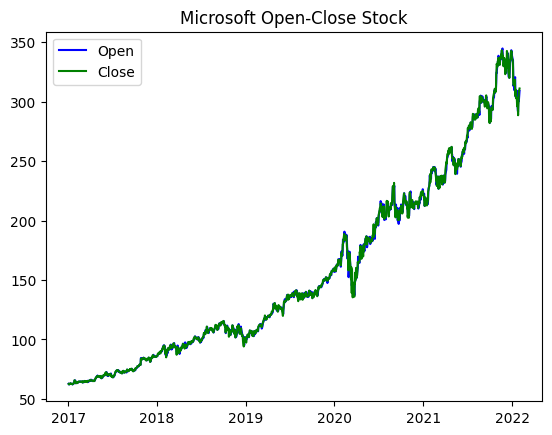

In [29]:
plt.plot(msft['Date'],msft['Open'],color="blue",label="Open")
plt.plot(msft['Date'],msft['Close'],color="green", label="Close")
plt.title("Microsoft Open-Close Stock")
plt.legend()

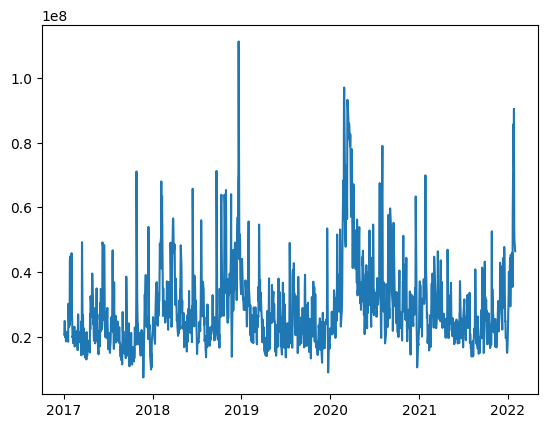

In [30]:
plt.plot(msft['Date'],msft['Volume'])
plt.show()

In [13]:
close_data = msft.filter(items=['close','tradedate'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .7))
print(training)

880


In [14]:

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

ValueError: could not convert string to float: '2018-08-30'

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

In [ ]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

In [ ]:
future_date = "2023-08-30"
future_dt = scaler.transform(future_date)
print(future_dt)

In [ ]:
train = msft[:training]
test = msft[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['tradedate'], train['close'])
plt.plot(test['tradedate'], test[['close', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [ ]:
model.save("../stock_predict.keras")